<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230317.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta
import os
import re
from functools import reduce 
from collections import defaultdict 
from scipy import stats
from scipy.stats import norm

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'sales_data_with_stores.csv',
 'test.csv',
 'groceries.csv',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'bz_data_analyis.csv',
 'online_retail_II.xlsx',
 'sales.csv',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 'sample-sales-data.csv',
 'mock_sales_data.csv',
 'cookie_cats.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'scanner_data.csv',
 'app_wau.csv',
 'ecommerce-data.csv',
 'mall_customers.csv',
 'lead_conversion.csv',
 '1_customers_dataset.csv',
 'ab_experiment.csv',
 '1_order_payments_dataset.csv',
 'online_retail.xlsx',
 'match_result_test.csv',
 '1_orders_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sales_vs_discount.csv',
 'sample_data']

In [3]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
cnt = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name = 'result')
cnt = cnt.groupby(['version','retention','result'])['userid'].count().reset_index(name = 'cnt')
cnt = cnt[cnt['result'] == True]
c

,version,retention,result,cnt
1,gate_30,retention_1,True,20034
3,gate_30,retention_7,True,8502
5,gate_40,retention_1,True,20119
7,gate_40,retention_7,True,8279


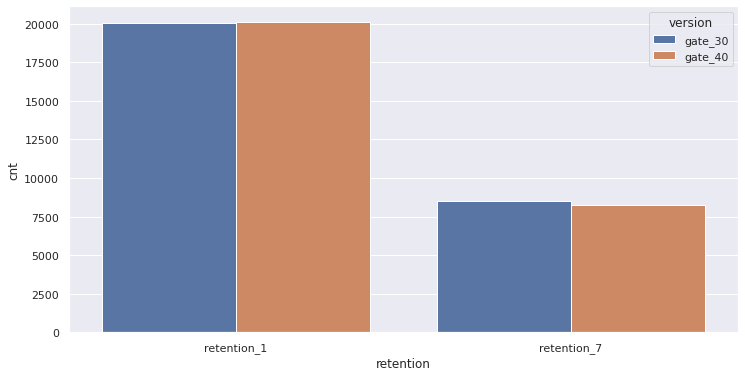

In [6]:
sns.set(rc = {'figure.figsize':[12,6]})
sns.barplot(data = cnt, x = 'retention', y = 'cnt', hue = 'version')
plt.show()

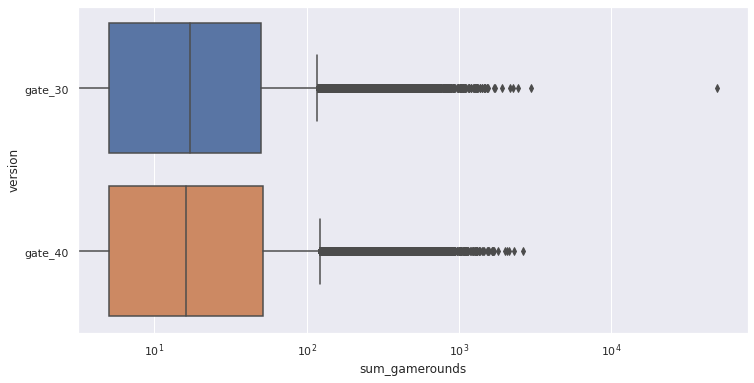

In [10]:
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

In [11]:
df = df[df['sum_gamerounds'] <= 10000]

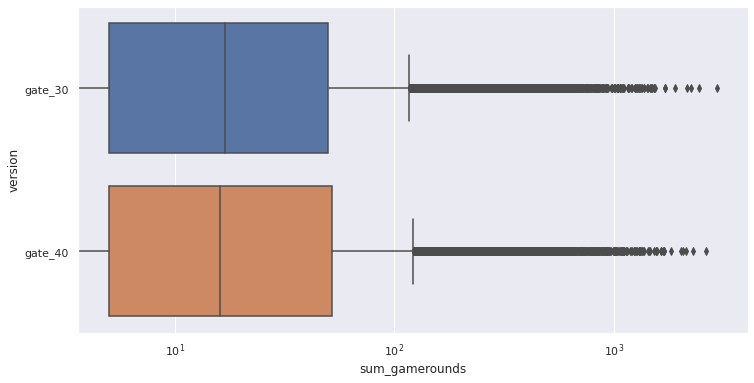

In [12]:
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

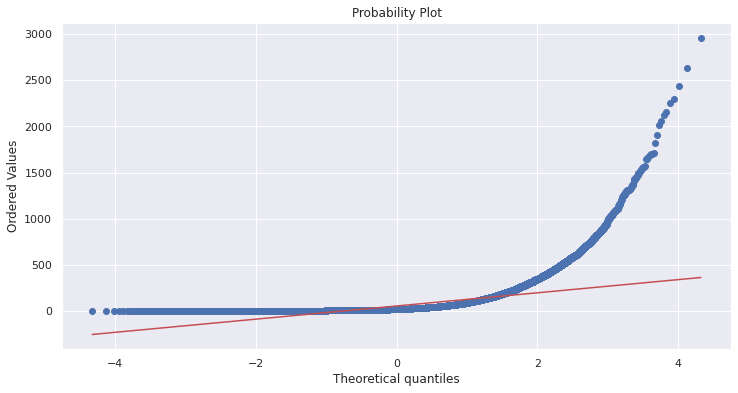

In [13]:
stats.probplot(df['sum_gamerounds'], dist = 'norm', plot = plt)
plt.show()

In [18]:
stat, p = stats.chisquare(df['sum_gamerounds'])
print(f'{round(stat,3)} {round(p,3)}')

18528909.99 0.0


In [20]:
res = stats.anderson(df['sum_gamerounds'])
res2 = zip(res.critical_values, res.significance_level)

In [21]:
[f'Probably Gaussian : critical level is {crit}, significance level is {sig}'
 if crit > sig
 else f'Probably not Gaussian : critical level is {crit}, significance level is {sig}'
 for crit, sig in res2
]

['Probably not Gaussian : critical level is 0.576, significance level is 15.0',
 'Probably not Gaussian : critical level is 0.656, significance level is 10.0',
 'Probably not Gaussian : critical level is 0.787, significance level is 5.0',
 'Probably not Gaussian : critical level is 0.918, significance level is 2.5',
 'Probably Gaussian : critical level is 1.092, significance level is 1.0']

In [22]:
n = 1000
boots = pd.DataFrame(
    [df.sample(frac = .1, replace = True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)]
)
boots.head()

version,gate_30,gate_40
sum_gamerounds,50.064246,52.487260
sum_gamerounds,51.780499,52.032399
sum_gamerounds,50.326859,49.954405
sum_gamerounds,50.807966,51.543646
sum_gamerounds,51.648540,48.612312


In [23]:
diff = boots['gate_30'] - boots['gate_40']
len(diff[diff > 0])/n

0.526

<Axes: ylabel='Density'>

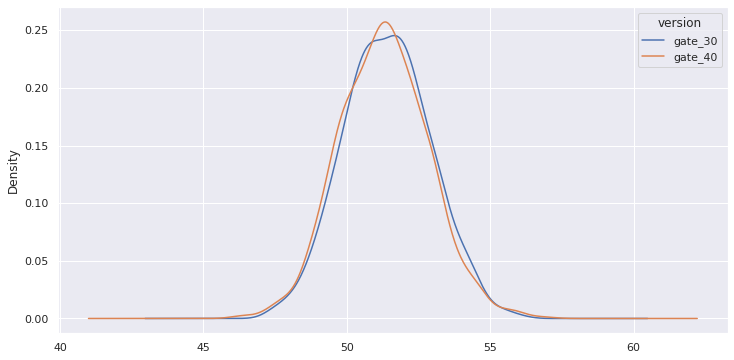

In [31]:
boots.plot.kde()

In [33]:
z_mean = np.mean(boots['gate_30']) - np.mean(boots['gate_40'])
z_sigma = np.sqrt(
    np.var(boots['gate_30'])/n + np.var(boots['gate_40'])/n
)
alpha = .05
ci_diff = [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma]

In [36]:
print(f'Z Mean : {z_mean}\nZ Sigma : {z_sigma}\nCI Diff : {ci_diff[0]}, {ci_diff[1]}')

Z Mean : 0.12119702976898594
Z Sigma : 0.06809433965885367
CI Diff : -0.012265423513404733, 0.25465948305137664


Text(0.5, 1.0, 'difference of bootstrapped gamerounds')

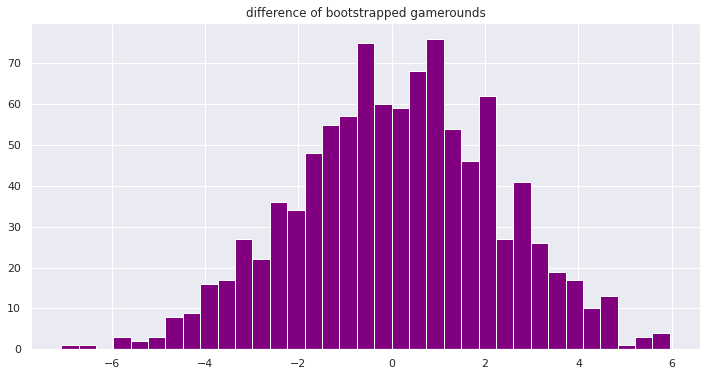

In [37]:
plt.hist(diff, bins = 35, color = 'purple')
plt.title('difference of bootstrapped gamerounds')

In [24]:
ret_1 = pd.crosstab(df['version'], df['retention_1'])
ret_7 = pd.crosstab(df['version'], df['retention_7'])

In [25]:
stats.chi2_contingency(ret_1)

Chi2ContingencyResult(statistic=3.169835543170799, pvalue=0.07500999897705693, dof=1, expected_freq=array([[24798.35970417, 19900.64029583],
       [25236.64029583, 20252.35970417]]))

In [28]:
def get_chi2(data) :
  stat, p, dof, ex = stats.chi2_contingency(data)
  alpha = .05
  res1 = f'P : {round(p, 3)} > alpha : {alpha}' if p > alpha else f'P : {round(p, 3)} < alpha : {alpha}'
  res2 = 'Not enough evidence to reject H0' if p > alpha else 'two groups are different'
  print(res1)
  print(res2)
  print(f'stat : {round(stat,3)}, p : {round(p, 3)}, dof : {dof}, ex : {ex}')

In [29]:
get_chi2(ret_1)

P : 0.075 > alpha : 0.05
Not enough evidence to reject H0
stat : 3.17, p : 0.075, dof : 1, ex : [[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]


In [30]:
get_chi2(ret_7)

P : 0.002 < alpha : 0.05
two groups are different
stat : 9.915, p : 0.002, dof : 1, ex : [[36382.49203885  8316.50796115]
 [37025.50796115  8463.49203885]]


# Iterators

In [38]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [39]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in users[0].keys()}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [40]:
{k : [user[k] for user in users] for k in users[0].keys()}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}